# Assignment 2 Task 4 Similarity Search 
* From my understanding similarity search allows us to use feature vectors and compare then with a database of previous feature vector to find similar vectors that we can use to classify the new image. 
* 

# Setup


In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


class SimpleCNN(nn.Module):
    # Constructor
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional Blocks (Conv -> ReLU -> Pool)
        # Block 1
        self.conv1 = nn.Conv2d(
            in_channels=3,  # 3 for RGB images
            out_channels=16,  # 16 filters
            kernel_size=3,  # 3x3 filter
            padding=1,
        )  # Keeps image size the same
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsamples by 2

        # Dropout to prevent overfitting
        self.dropout1 = nn.Dropout2d(p=0.2)

        # Block 2
        self.conv2 = nn.Conv2d(
            in_channels=16,  # Must match out_channels of conv1
            out_channels=32,
            kernel_size=3,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout2 = nn.Dropout2d(p=0.2)

        self.conv3 = nn.Conv2d(
            in_channels=32,  # Must match out_channels of conv1
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(p=0.2)

        # --- Define the Classifier "Head" ---
        # This part flattens the 3D feature map to a 1D vector
        # Example calculation for 224x224 images:
        # 224 -> pool1 -> 112 -> pool2 -> 56 -> pool3 -> 28
        # So the flattened size will be: 64 (channels) * 28 (height) * 28 (width)
        # use nn.Flatten() to do this automatically

        self.flatten = nn.Flatten()

        # 64 channels * 28 H * 28 W = 50,176

        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=128)
        self.relu3 = nn.ReLU()

        self.dropoutfc1 = nn.Dropout(p=0.5)

        # 1 neuron for binary classification (cat vs. dog)
        self.fc2 = nn.Linear(in_features=128, out_features=1)

    # Forward Pass
    def forward(self, x):
        # 'x' is the input batch of images
        # Shape: [batch_size, 3, 224, 224]

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        # Shape is [batch_size, 16, 112, 112]

        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # Shape is [batch_size, 32, 56, 56]

        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        # Shape is [batch_size, 64, 28, 28]

        x = self.dropout3(x)

        x = self.flatten(x)
        # Shape is [batch_size, 50,176]

        x = self.fc1(x)
        x = self.relu3(x)
        # Shape is [batch_size, 128]

        x = self.dropoutfc1(x)

        x = self.fc2(x)
        # Shape is [batch_size, 1]

        return x

In [ ]:
IMG_SIZE = 224
val_test_transforms = transforms.Compose(
    [
        transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        # Use the *exact* mean/std you used for training
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Define  test directory
test_dir = "/workspaces/eng-ai-agents/assignments/assignment-2/data/test"  # <--- SET THIS PATH

test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a new, un-trained instance of the model
base_model = SimpleCNN().to(device)

# Load saved weights
base_model.load_state_dict(torch.load("best_model_72.pth"))
base_model.eval()


/tmp/ipykernel_23782/3246712754.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load("best_model_71.pth"))


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=

In [3]:
modules = list(base_model.children())
print(modules)
modules.pop()

feature_extractor = nn.Sequential(*modules)
feature_extractor.to(device)
feature_extractor.eval()

[Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Dropout2d(p=0.2, inplace=False), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Dropout2d(p=0.2, inplace=False), Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Dropout2d(p=0.2, inplace=False), Flatten(start_dim=1, end_dim=-1), Linear(in_features=50176, out_features=128, bias=True), Dropout(p=0.5, inplace=False), Linear(in_features=128, out_features=1, bias=True)]


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout2d(p=0.2, inplace=False)
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout2d(p=0.2, inplace=False)
  (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Dropout2d(p=0.2, inplace=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=50176, out_features=128, bias=T

In [4]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct
import uuid

# This creates a persistent, on-disk database in a new folder
client = QdrantClient(path="./qdrant_storage")

COLLECTION_NAME = "image_vectors"
VECTOR_SIZE = 128

# Create the "collection" (like a table in SQL)
client.recreate_collection(
    collection_name=COLLECTION_NAME, vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE)
)
print(f"Collection '{COLLECTION_NAME}' created.")

# Loop through your dataset and index every image
points_to_upload = []
for i in range(len(test_dataset)):
    image_tensor, label = test_dataset[i]
    filepath, _ = test_dataset.imgs[i]  # .imgs gives (path, label)

    # Get the feature vector
    with torch.no_grad():
        # Use the feature_extractor model to get the features
        vec_tensor = feature_extractor(image_tensor.unsqueeze(0).to(device))

    # Convert vector to a standard Python list
    vector_list = vec_tensor.squeeze().cpu().numpy().tolist()

    # Create the data we want to get back
    point = PointStruct(id=i, vector=vector_list, payload={"filepath": filepath, "label": label})
    points_to_upload.append(point)

# Upload all points to the database
client.upsert(collection_name=COLLECTION_NAME, points=points_to_upload, wait=True)

print(f"Successfully indexed {len(points_to_upload)} images.")

/tmp/ipykernel_23782/549959726.py:12: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


Collection 'image_vectors' created.
Successfully indexed 1000 images.



--- QUERY 1 (True Label: Dog) ---


/tmp/ipykernel_23782/4168345090.py:31: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


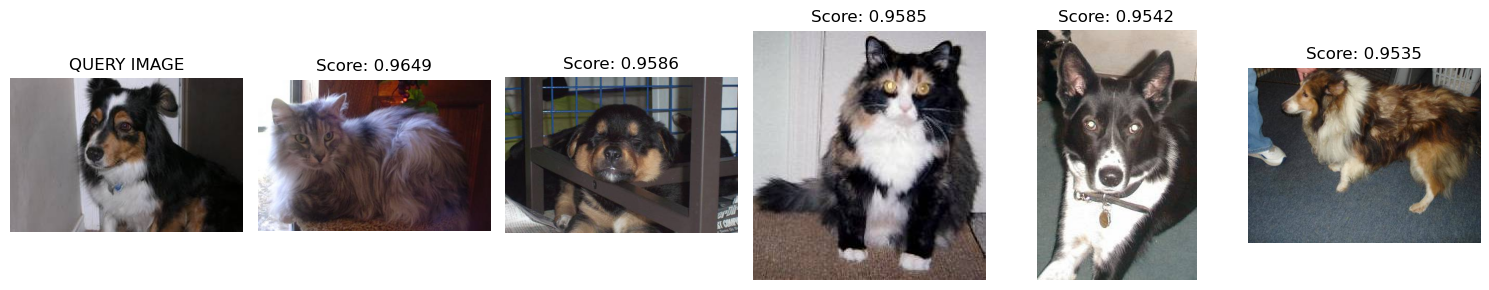


--- QUERY 2 (True Label: Dog) ---


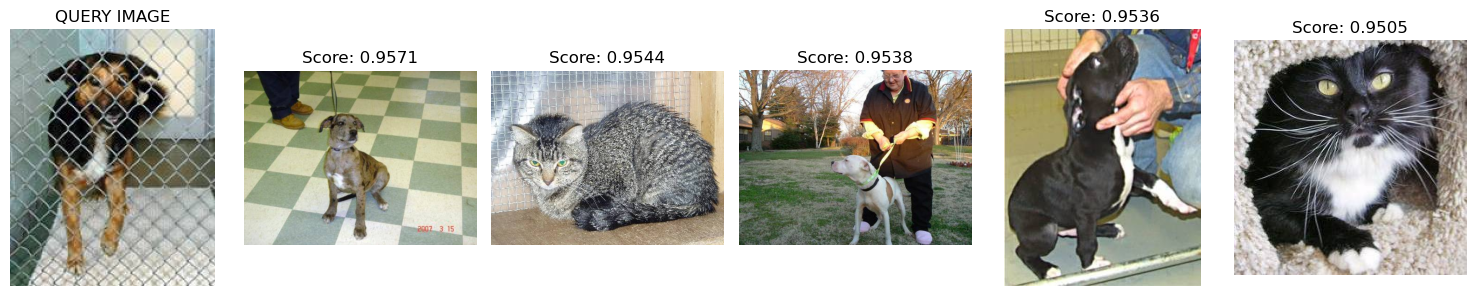


--- QUERY 3 (True Label: Dog) ---


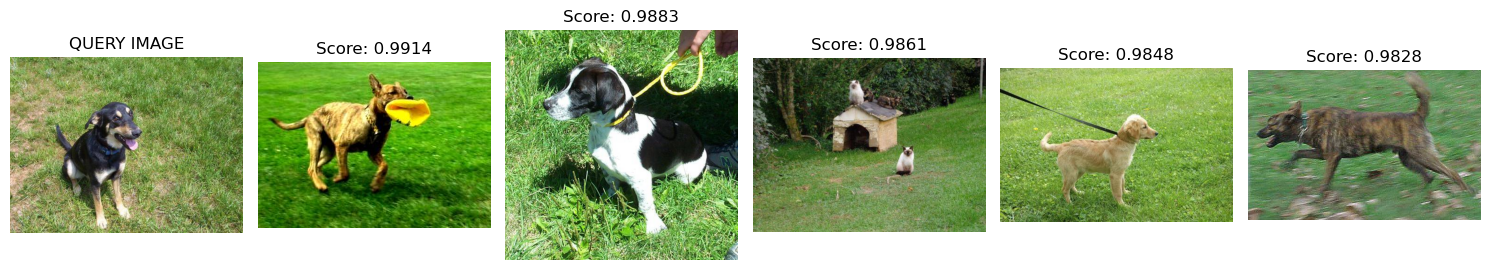

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image


def show_image(filepath, title=""):
    """Helper function to plot an image from its file path."""
    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")


k = 5  # How many similar images to find
num_queries = 3  # How many random images to test

query_indices = random.sample(range(len(test_dataset)), num_queries)

# Loop through your 3 query images
for i, query_index in enumerate(query_indices):
    # Get the query image's path and vector
    query_tensor, query_label = test_dataset[query_index]
    query_path, _ = test_dataset.imgs[query_index]

    with torch.no_grad():
        query_vector = feature_extractor(query_tensor.unsqueeze(0).to(device))

    query_vector_list = query_vector.squeeze().cpu().numpy().tolist()

    # Search Qdrant
    search_results = client.search(
        collection_name=COLLECTION_NAME,
        query_vector=query_vector_list,
        limit=k + 1,  # Get k+1 results (since the image itself will be one)
    )

    print(f"\n--- QUERY {i + 1} (True Label: {'Dog' if query_label == 1 else 'Cat'}) ---")

    plt.figure(figsize=(15, 3))

    # Plot the query image
    plt.subplot(1, k + 1, 1)
    show_image(query_path, title="QUERY IMAGE")

    # Plot the k results
    plot_index = 2
    for result in search_results:
        if result.id == query_index:
            continue

        result_path = result.payload["filepath"]
        result_score = result.score

        plt.subplot(1, k + 1, plot_index)
        show_image(result_path, title=f"Score: {result_score:.4f}")
        plot_index += 1

    plt.tight_layout()
    plt.show()